## Import libraries

In [ ]:
# Fix randomness and hide warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import logging
import random

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.13.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

## Data preprocessing

Note: this part is the same as of *conv-lstm-attention.ipynb*. Check there for more details and explainations.

In [ ]:
data = np.load('/kaggle/input/challenge2/training_data.npy', allow_pickle=True)
categories = np.load('/kaggle/input/challenge2/categories.npy', allow_pickle=True)
periods = np.load('/kaggle/input/challenge2/valid_periods.npy', allow_pickle=True)

In [ ]:
df = pd.DataFrame(data=data)
print(df.shape)

(48000, 2776)


In [ ]:
df = df.astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
df['Start'] = periods[:,0]
df['End'] = periods[:,1]

In [ ]:
df['Category'] = categories

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,Start,End,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.601933,0.639848,0.409208,0.151259,0.183186,0.266565,0.403581,2703,2776,C
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.754183,0.740621,0.724421,0.721276,0.702341,0.708480,0.720463,2581,2776,B
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.562132,0.627639,0.661737,0.643021,0.640349,0.598605,0.639099,2613,2776,B
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.675498,0.679844,0.690941,0.688087,0.713021,0.723866,0.690007,2595,2776,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664118,0.742549,0.777290,0.773533,0.792240,0.764940,0.728696,2362,2776,D
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.530155,0.594949,0.533755,0.557655,0.582954,0.153346,0.125604,2538,2776,D
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.505081,0.534742,0.383979,0.399032,0.342313,0.335126,0.525874,2703,2776,C
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.317073,0.268293,0.170732,0.121951,0.121951,0.146341,0.195122,2725,2776,E
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645161,0.766129,0.782258,0.782258,0.717742,0.750000,0.645161,2726,2776,E
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.961480,0.963265,0.960204,0.939286,0.921684,0.864286,0.865051,2560,2776,C


## Splitting and Windowing

In [ ]:
def build_test_set(df, test_size):
    test_df = pd.DataFrame(columns=df.columns)

    for category in df['Category'].unique():
        temp_df = df[df['Category'] == category][:test_size]
        test_df = pd.concat([test_df, temp_df], ignore_index=True)
        df = df.drop(temp_df.index)

    df = df.reset_index(drop=True)
    return df, test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
df, test_df = build_test_set(df, 27)

In [ ]:
df, val_df = build_test_set(df, 27)

In [ ]:
intersection_test = df.merge(test_df).empty
print(intersection_test)
intersection_val = val_df.merge(test_df).empty
print(intersection_val)

True
True


In [ ]:
window = 200
telescope = 9
autoregressive_tel = 1
stride = 20

In [ ]:
def build_sequences(row, dataset, labels, window=200, telescope=9, stride=20):
    assert window % stride == 0
    row = row[int(row.Start):int(row.End)]
    padding_check = len(row)%window

    if(padding_check != 0):
        padding_len = window - len(row)%window
        padding = np.zeros(padding_len, dtype='float32')
    else:
        padding = np.zeros(0)

    temp_row = np.concatenate((padding,row))
    assert len(temp_row) % window == 0

    for idx in np.arange(0, len(temp_row)-window-telescope, stride):
        dataset.append(temp_row[idx:idx+window])
        labels.append(temp_row[idx+window:idx+window+telescope])

    del temp_row

In [ ]:
training_dataset = []
training_labels = []

for row in df.itertuples():
    build_sequences(row, training_dataset, training_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

In [ ]:
training_dataset = np.expand_dims(np.array(training_dataset), axis=2)
training_labels = np.expand_dims(np.array(training_labels), axis=1)

In [ ]:
print(training_dataset.shape)
print(training_labels.shape)

(267310, 200, 1)
(267310, 1, 1)


In [ ]:
validation_dataset = []
validation_labels = []

for row in val_df.itertuples():
    build_sequences(row, validation_dataset, validation_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

validation_dataset = np.expand_dims(np.array(validation_dataset), axis=2)
validation_labels = np.expand_dims(np.array(validation_labels), axis=1)

In [ ]:
print(validation_dataset.shape)
print(validation_labels.shape)

(950, 200, 1)
(950, 1, 1)


In [ ]:
test_dataset = []
test_labels = []

for row in test_df.itertuples():
    build_sequences(row, test_dataset, test_labels, window=window,
                    telescope=autoregressive_tel, stride=stride)

test_dataset = np.expand_dims(np.array(test_dataset), axis=2)
test_labels = np.expand_dims(np.array(test_labels), axis=1)

In [ ]:
print(test_dataset.shape)
print(test_labels.shape)

(1050, 200, 1)
(1050, 1, 1)


## 1DCNN ResNet

In [ ]:
input_shape = training_dataset.shape[1:]
output_shape = training_labels.shape[1:]
print(input_shape, output_shape)

batch_size = 64
epochs = 150

(200, 1) (1, 1)


In [ ]:
# Model building function

def build_resnet_attention(input_shape, output_shape):
    n_feature_maps = 64
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    #input
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    y = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'))(input_layer)
    x = tfkl.Conv1D(256, 3, padding='same')(y)
    x = tfkl.MaxPooling1D(pool_size=2, padding='same')(x)

    #block 1
    conv_x = tfkl.Conv1D(n_feature_maps, 8, 1, padding='same')(x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('softmax')(conv_y)
    conv_y = tfkl.Dropout(.35, seed=seed)(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps, 1, 1,padding='same')(x)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #attention module
    y = tfkl.Attention()([y,y])

    #block 2
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('softmax')(conv_y)
    conv_y = tfkl.Dropout(.35, seed=seed)(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #attention module
    y = tfkl.Attention()([y,y])

    #block 3
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('softmax')(conv_y)
    conv_y = tfkl.Dropout(.35, seed=seed)(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #attention module
    y = tfkl.Attention()([y,y])

    # before output
    full = tfkl.GlobalAveragePooling1D(keepdims=True)(y)
    full = tfkl.Dropout(.5, seed=seed)(full)

    # Output block
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(full)

    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='1DConvResNet')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))

    return model

Model: "1DConvResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 200, 256)             133120    ['input_layer[0][0]']         
 al)                                                                                              
                                                                                                  
 conv1d (Conv1D)             (None, 200, 256)             196864    ['bidirectional[0][0]']       
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 100, 256)             0         ['conv1d[0][0]']   

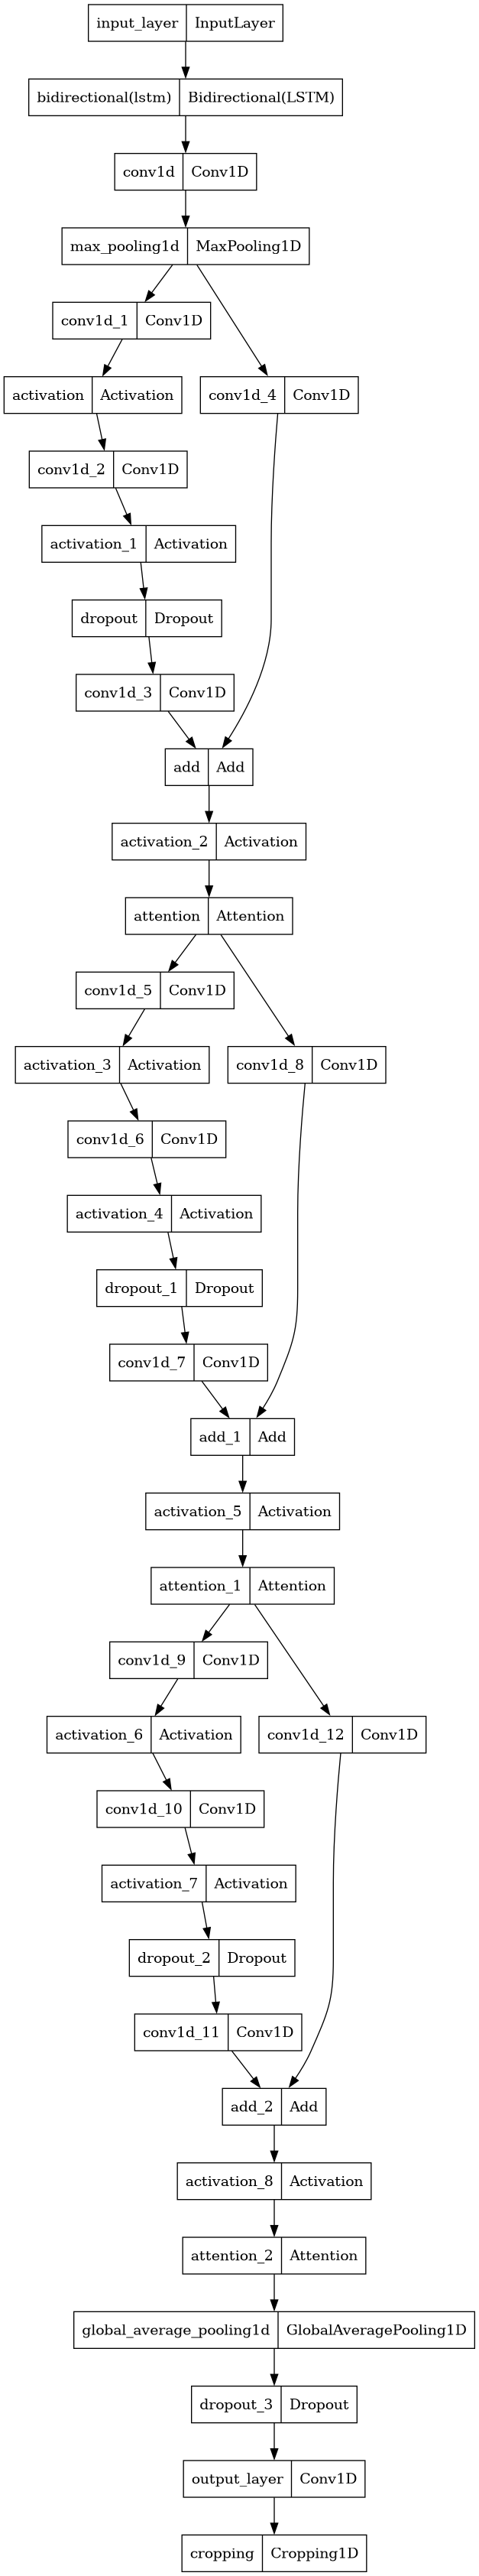

In [ ]:
model = build_resnet_attention(input_shape, output_shape)
model.summary()

from keras.utils import plot_model

plot_model(model, 'model.png')

In [ ]:
history = model.fit(
    x = training_dataset,
    y = training_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (validation_dataset, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-6)
    ]
).history

# a good result is in the order of 10^-3

Epoch 1/150
4177/4177 [==============================] - 179s 38ms/step - loss: 0.0096 - val_loss: 0.0041 - lr: 0.0010
Epoch 2/150
4177/4177 [==============================] - 155s 37ms/step - loss: 0.0073 - val_loss: 0.0048 - lr: 0.0010
Epoch 3/150
4177/4177 [==============================] - 153s 37ms/step - loss: 0.0055 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/150
4177/4177 [==============================] - 152s 36ms/step - loss: 0.0053 - val_loss: 0.0034 - lr: 0.0010
Epoch 5/150
4177/4177 [==============================] - 152s 36ms/step - loss: 0.0050 - val_loss: 0.0033 - lr: 0.0010
Epoch 6/150
4177/4177 [==============================] - 153s 37ms/step - loss: 0.0048 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/150
4177/4177 [==============================] - 152s 36ms/step - loss: 0.0047 - val_loss: 0.0033 - lr: 0.0010
Epoch 8/150
4177/4177 [==============================] - 153s 37ms/step - loss: 0.0045 - val_loss: 0.0034 - lr: 0.0010
Epoch 9/150
4177/4177 [=========================

## Results and testing

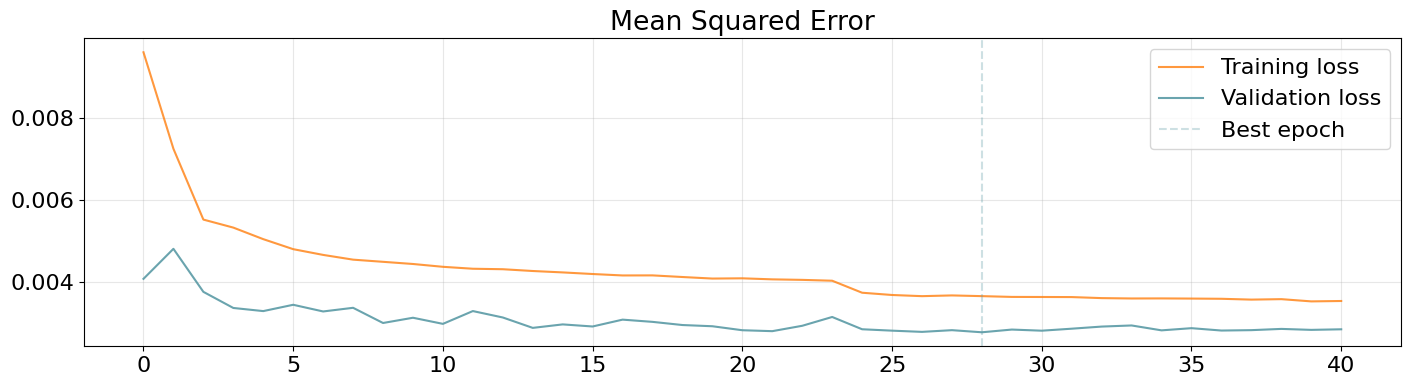

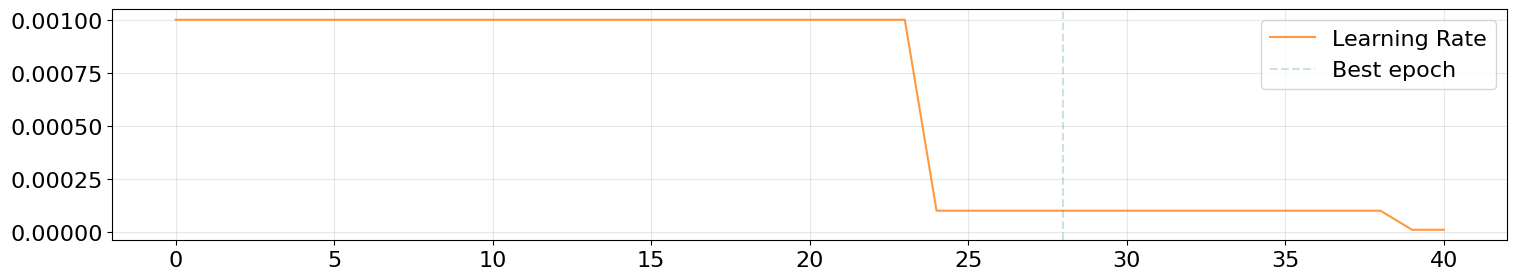

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# compute performance over test set

predictions = model.predict(test_dataset, verbose=0)

print(f"Predictions shape: {predictions.shape}")

mean_squared_error = tfk.metrics.mean_squared_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1050, 1, 1)
Mean Squared Error: 0.0016497625038027763
Mean Absolute Error: 0.023030035197734833


## Predict more samples

In [ ]:
test_dataset_multistep = []
test_labels_multistep = []

for row in test_df.itertuples():
    build_sequences(row, test_dataset_multistep, test_labels_multistep,
                    window=window, telescope=telescope, stride=stride)

test_dataset_multistep = np.expand_dims(np.array(test_dataset_multistep), axis=2)
test_labels_multistep = np.expand_dims(np.array(test_labels_multistep), axis=2)

In [ ]:
test_dataset_multistep.shape, test_labels_multistep.shape

((1050, 200, 1), (1050, 9, 1))

In [ ]:
def predict_multistep(model, X_test, telescope=9, autoregressive_telescope=1):
    # Autoregressive Forecasting
    predictions = np.array([])
    X_temp = X_test
    for reg in range(0,telescope,autoregressive_telescope):
        pred = model.predict(X_temp,verbose=0)
        if(len(predictions)==0):
            predictions = pred
        else:
            predictions = np.concatenate((predictions,pred),axis=1)
        X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred), axis=1)

    return predictions

In [ ]:
prediction_multistep = predict_multistep(model, test_dataset_multistep,
                                         telescope=telescope,
                                         autoregressive_telescope=autoregressive_tel)

In [ ]:
# measure performance over output window of 9/18 samples

print(f"Predictions shape: {prediction_multistep.shape}")

mean_squared_error = tfk.metrics.mean_squared_error(test_labels_multistep.flatten(),
                                                    prediction_multistep.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels_multistep.flatten(),
                                                      prediction_multistep.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1050, 9, 1)
Mean Squared Error: 0.006620681844651699
Mean Absolute Error: 0.051393892616033554


In [ ]:
# model.save('DirectForecasting')
model.save('/kaggle/working/1DCnnResNetSelfAttention')